<a href="https://colab.research.google.com/github/Nidarshan619/pyts/blob/master/Timeseries_Deep_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt


In [ ]:
#Experimentation
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialWithAnomaly/art_load_balancer_spikes.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

fig, ax = plt.subplots()
df_small_noise.plot(legend=True, ax=ax)
plt.show()

In [ ]:
data = pd.read_csv("Va_values.csv",parse_dates=True, index_col="Timestamps")
print(data.head())


                               Values
Timestamps                           
2021-07-28 19:43:13.733  10744.049805
2021-07-28 19:43:13.750  10744.085938
2021-07-28 19:43:13.767  10744.056641
2021-07-28 19:43:13.783  10744.049805
2021-07-28 19:43:13.800  10744.084961


                             Values_1      Values_2  ...  Values_11  Values_12
Timestamps                                           ...                      
2011-01-09 04:38:12.183  10511.708008  10511.782227  ...   0.000083   0.023823
2011-01-09 04:38:12.200  10511.740234  10511.778320  ...   0.000067   0.020471
2011-01-09 04:38:12.217  10511.729492  10511.753906  ...   0.000058   0.023348
2011-01-09 04:38:12.233  10511.710938  10511.782227  ...   0.000057   0.023872
2011-01-09 04:38:12.250  10511.742188  10511.778320  ...   0.000053   0.020449

[5 rows x 12 columns]


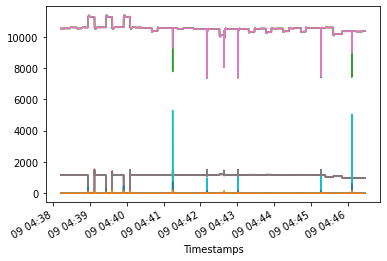

In [5]:
fig, ax = plt.subplots()
data.plot(legend=False, ax=ax)
plt.show()

Values    10744.00828
dtype: float64
Values    4.952786
dtype: float64
                           Values
Timestamps                       
2021-07-28 19:43:13.733  0.008384
2021-07-28 19:43:13.750  0.015680
2021-07-28 19:43:13.767  0.009764
2021-07-28 19:43:13.783  0.008384
2021-07-28 19:43:13.800  0.015482
...                           ...
2021-07-28 19:51:28.400  0.009173
2021-07-28 19:51:28.417  0.014694
2021-07-28 19:51:28.433  0.010356
2021-07-28 19:51:28.450  0.009173
2021-07-28 19:51:28.467  0.014694

[29685 rows x 1 columns]
Number of training samples: 29685


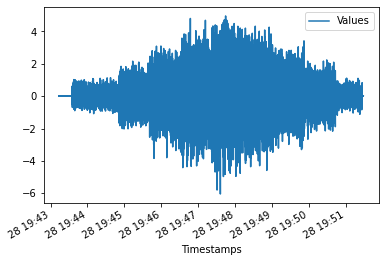

In [ ]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = data.mean()
print(training_mean)
training_std = data.std()
print(training_std)
df_training_value = (data - training_mean) / training_std
print(df_training_value)
print("Number of training samples:", len(df_training_value))
df_training_value.plot()
plt.show()

Training input shape:  (29398, 288, 1)


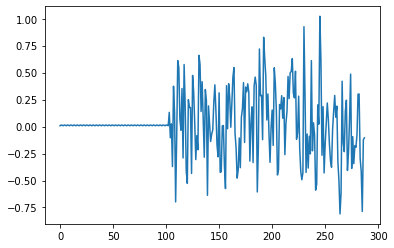

In [ ]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)
plt.plot(x_train[1200])
plt.show()

In [ ]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 144, 32)           256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 144, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose_3 (Conv1DTr (None, 144, 16)           1808      
_________________________________________________________________
dropout_3 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_4 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_5 (Conv1DTr (None, 288, 1)           

In [ ]:
history = model.fit(
    x_train,
    x_train,
    epochs=25,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/25
207/207 [==============================] - 16s 74ms/step - loss: 0.2938 - val_loss: 0.0035
Epoch 2/25
207/207 [==============================] - 15s 73ms/step - loss: 0.1111 - val_loss: 0.0025
Epoch 3/25
207/207 [==============================] - 15s 73ms/step - loss: 0.0944 - val_loss: 0.0029
Epoch 4/25
207/207 [==============================] - 15s 74ms/step - loss: 0.0736 - val_loss: 0.0055
Epoch 5/25
207/207 [==============================] - 15s 74ms/step - loss: 0.0590 - val_loss: 0.0074
Epoch 6/25
207/207 [==============================] - 15s 73ms/step - loss: 0.0507 - val_loss: 0.0084
Epoch 7/25
207/207 [==============================] - 15s 74ms/step - loss: 0.0460 - val_loss: 0.0086


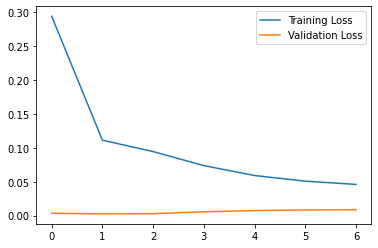

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

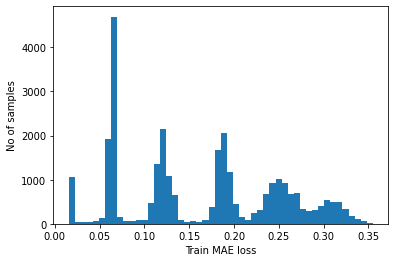

Reconstruction error threshold:  0.35499333342052963


In [ ]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
len(train_mae_loss)
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

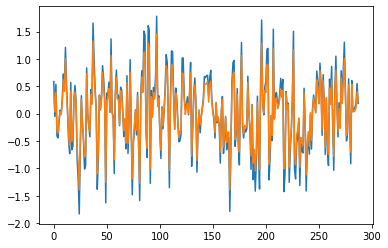

In [ ]:
# Checking how the first sequence is learnt
plt.plot(x_train[8000])
plt.plot(x_train_pred[8000])
plt.show()

In [ ]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url,parse_dates=True, index_col="timestamp"
)

In [ ]:
print(df_small_noise.head())

print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


In [ ]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

value    42.438353
dtype: float64
value    28.077122
dtype: float64
                        value
timestamp                    
2014-04-01 00:00:00 -0.858829
2014-04-01 00:05:00 -0.728993
2014-04-01 00:10:00 -0.848148
2014-04-01 00:15:00 -0.729586
2014-04-01 00:20:00 -0.731173
...                       ...
2014-04-14 23:35:00 -0.791647
2014-04-14 23:40:00 -0.780255
2014-04-14 23:45:00 -0.833640
2014-04-14 23:50:00 -0.735102
2014-04-14 23:55:00 -0.846089

[4032 rows x 1 columns]
Number of training samples: 4032


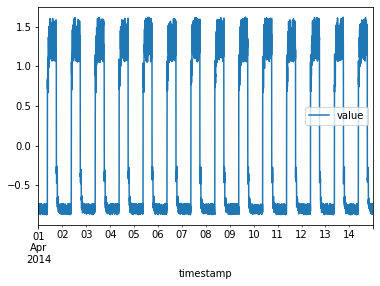

In [ ]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
print(training_mean)
training_std = df_small_noise.std()
print(training_std)
df_training_value = (df_small_noise - training_mean) / training_std
print(df_training_value)
print("Number of training samples:", len(df_training_value))
df_training_value.plot()
plt.show()

In [ ]:
print(len(df_training_value.values))
for i in range(4032 - 288 + 1):
  print(i)


Training input shape:  (3745, 288, 1)


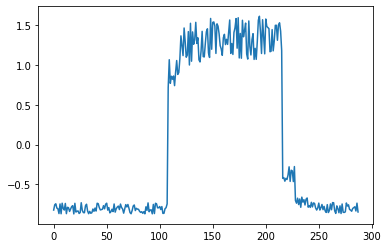

In [ ]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)
plt.plot(x_train[3744])
plt.show()

In [ ]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


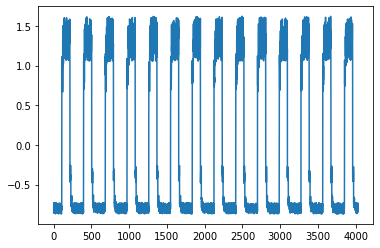

Number of training samples: 4032


In [ ]:
from scipy import stats
x = stats.zscore(df_small_noise)
plt.plot(x) 
plt.show()
print("Number of training samples:", len(x))

In [ ]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


In [ ]:
x_train.shape[1]

288

In [ ]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 144, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 144, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 144, 16)           1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 288, 1)            2

In [ ]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 4s 94ms/step - loss: 0.5154 - val_loss: 0.0599
Epoch 2/50
27/27 [==============================] - 2s 89ms/step - loss: 0.0782 - val_loss: 0.0412
Epoch 3/50
27/27 [==============================] - 2s 88ms/step - loss: 0.0570 - val_loss: 0.0359
Epoch 4/50
27/27 [==============================] - 2s 87ms/step - loss: 0.0489 - val_loss: 0.0325
Epoch 5/50
27/27 [==============================] - 2s 87ms/step - loss: 0.0434 - val_loss: 0.0300
Epoch 6/50
27/27 [==============================] - 2s 89ms/step - loss: 0.0387 - val_loss: 0.0271
Epoch 7/50
27/27 [==============================] - 2s 88ms/step - loss: 0.0341 - val_loss: 0.0232
Epoch 8/50
27/27 [==============================] - 2s 88ms/step - loss: 0.0303 - val_loss: 0.0211
Epoch 9/50
27/27 [==============================] - 2s 91ms/step - loss: 0.0275 - val_loss: 0.0193
Epoch 10/50
27/27 [==============================] - 2s 89ms/step - loss: 0.0254 - val_loss: 0.0197
Epoch 11/

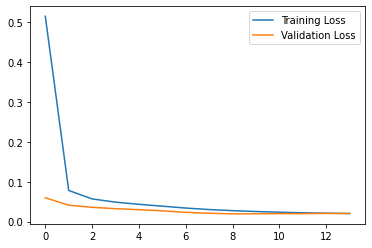

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

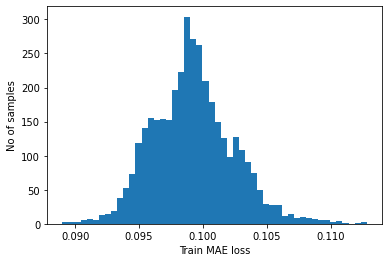

Reconstruction error threshold:  0.1128241895850792


In [ ]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
len(train_mae_loss)
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [ ]:
print(len(train_mae_loss))

3745


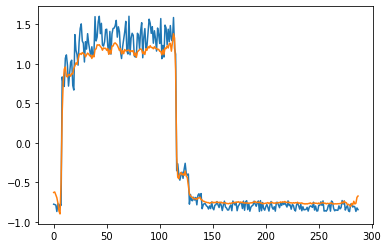

In [ ]:
# Checking how the first sequence is learnt
plt.plot(x_train[100])
plt.plot(x_train_pred[100])
plt.show()

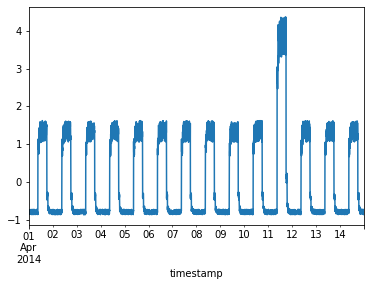

Test input shape:  (3745, 288, 1)


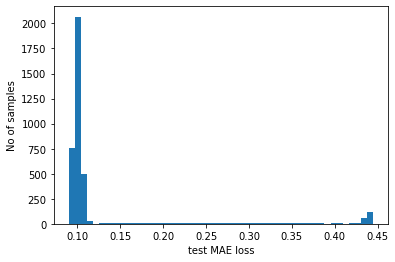

Number of anomaly samples:  407
Indices of anomaly samples:  (array([ 785,  786,  788,  789, 1649, 1650, 1651, 1652, 1653, 1654, 1658,
       2517, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710,
       2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721,
       2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732,
       2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743,
       2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754,
       2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765,
       2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776,
       2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787,
       2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798,
       2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809,
       2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820,
       2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2

In [ ]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std 
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [ ]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

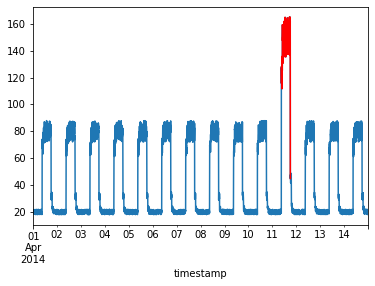

In [ ]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

# Training Phase

                               Values
Timestamps                           
2021-07-28 19:43:13.733  10744.049805
2021-07-28 19:43:13.750  10744.085938
2021-07-28 19:43:13.767  10744.056641
2021-07-28 19:43:13.783  10744.049805
2021-07-28 19:43:13.800  10744.084961


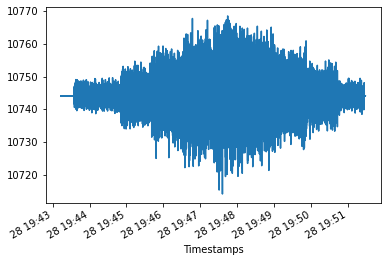

Values    10744.00828
dtype: float64
Values    4.952786
dtype: float64
                           Values
Timestamps                       
2021-07-28 19:43:13.733  0.008384
2021-07-28 19:43:13.750  0.015680
2021-07-28 19:43:13.767  0.009764
2021-07-28 19:43:13.783  0.008384
2021-07-28 19:43:13.800  0.015482
...                           ...
2021-07-28 19:51:28.400  0.009173
2021-07-28 19:51:28.417  0.014694
2021-07-28 19:51:28.433  0.010356
2021-07-28 19:51:28.450  0.009173
2021-07-28 19:51:28.467  0.014694

[29685 rows x 1 columns]
Number of training samples: 29685


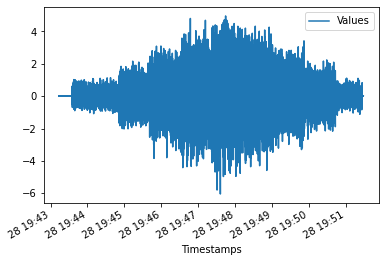

Training input shape:  (29398, 288, 1)


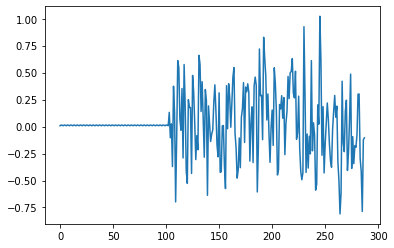

In [11]:
data = pd.read_csv("Va_values.csv",parse_dates=True, index_col="Timestamps")
print(data.head())
fig, ax = plt.subplots()
data.plot(legend=False, ax=ax)
plt.show()


# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = data.mean()
print(training_mean)
training_std = data.std()
print(training_std)
df_training_value = (data - training_mean) / training_std
print(df_training_value)
print("Number of training samples:", len(df_training_value))
df_training_value.plot()
plt.show()


TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)
plt.plot(x_train[1200])
plt.show()

In [12]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 144, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 144, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 144, 16)           1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 288, 1)            2

## Main Training

Epoch 1/25
207/207 [==============================] - 13s 58ms/step - loss: 0.2878 - val_loss: 0.0037
Epoch 2/25
207/207 [==============================] - 12s 59ms/step - loss: 0.1085 - val_loss: 0.0033
Epoch 3/25
207/207 [==============================] - 12s 60ms/step - loss: 0.0840 - val_loss: 0.0056
Epoch 4/25
207/207 [==============================] - 12s 60ms/step - loss: 0.0677 - val_loss: 0.0060
Epoch 5/25
207/207 [==============================] - 12s 58ms/step - loss: 0.0583 - val_loss: 0.0064
Epoch 6/25
207/207 [==============================] - 12s 58ms/step - loss: 0.0520 - val_loss: 0.0070
Epoch 7/25
207/207 [==============================] - 12s 59ms/step - loss: 0.0484 - val_loss: 0.0075


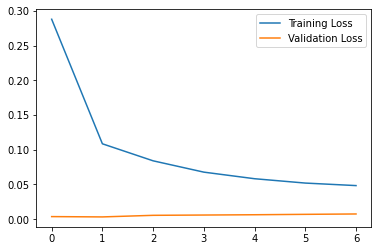

In [13]:
history = model.fit(
    x_train,
    x_train,
    epochs=25,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)


plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()


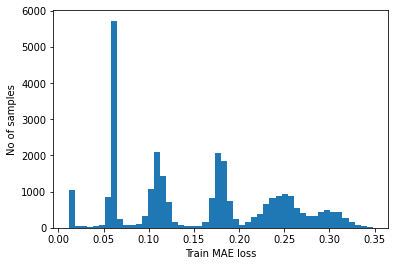

Reconstruction error threshold:  0.34818178805875644


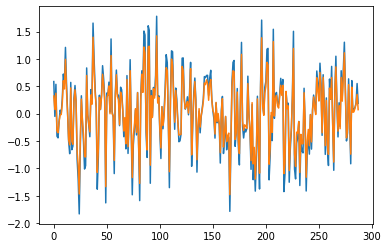

In [14]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
len(train_mae_loss)
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)



# Checking how the first sequence is learnt
plt.plot(x_train[8000])
plt.plot(x_train_pred[8000])
plt.show()

# Testing Phase 

                               Values
Timestamps                           
2021-07-28 19:43:13.733  10744.049805
2021-07-28 19:43:13.750  10744.085938
2021-07-28 19:43:13.767  10744.056641
2021-07-28 19:43:13.783  10744.049805
2021-07-28 19:43:13.800  10744.084961


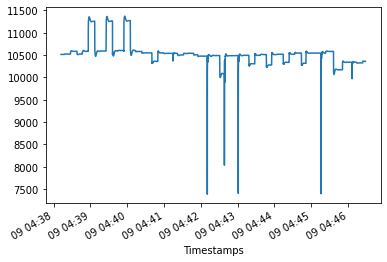

In [15]:
event = pd.read_csv("Va_events.csv",parse_dates=True, index_col="Timestamps")
print(data.head())
fig, ax = plt.subplots()
event.plot(legend=False, ax=ax)
plt.show()

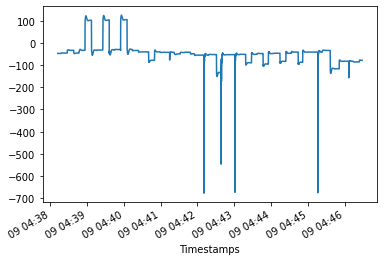

Test input shape:  (29499, 288, 1)


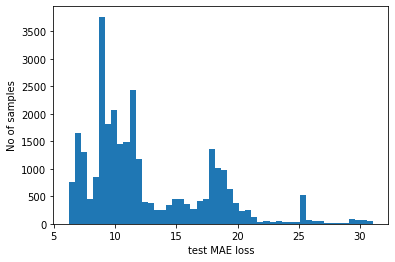

Number of anomaly samples:  29499
Indices of anomaly samples:  (array([    0,     1,     2, ..., 29496, 29497, 29498]),)


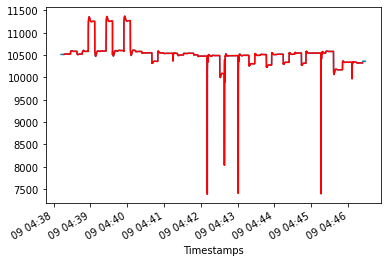

In [19]:
df_test_value = (event - training_mean) / training_std 
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))


# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

df_subset = event.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
event.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()